<a href="https://colab.research.google.com/github/akibkhan1/skin-lesion-classification/blob/main/Skin_Lesion_ISIC2018_Training_DenseNet_169.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Skin Lesion Classification on ISIC 2018 Dataset using transfer learning on various pretrained models

**Authors:**
<br>
Akib Mohammed Khan, Alif Asharafee, Fahim Shahriar Khan,
<br>
Islamic University of Techonology.

## Import models

In [1]:
import os
import zipfile
import random
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Model
from shutil import copyfile, move

In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 17534087346909650283, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14509932544
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 3108461277182573536
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"]

# Download training data

In [3]:
!gdown --id 10TNZNGbTaR2sZN7tL8riGZwBzJCWmWA6

Downloading...
From: https://drive.google.com/uc?id=10TNZNGbTaR2sZN7tL8riGZwBzJCWmWA6
To: /content/ISIC-split.zip
2.77GB [00:38, 72.0MB/s]


In [ ]:
!unzip ISIC-split.zip
!rm ISIC-split.zip

## Choose model to train

In [10]:
BASE_MODEL='DenseNet169'

In [20]:
from keras.preprocessing.image import ImageDataGenerator
if BASE_MODEL == 'MobileNet':
    from keras.applications.mobilenet_v2 import MobileNetV2 as PTModel, preprocess_input
elif BASE_MODEL=='VGG16':
    from keras.applications.vgg16 import VGG16 as PTModel, preprocess_input
elif BASE_MODEL=='VGG19':
    from keras.applications.vgg19 import VGG19 as PTModel, preprocess_input
elif BASE_MODEL=='RESNET50':
    from keras.applications.resnet50 import ResNet50 as PTModel, preprocess_input
elif BASE_MODEL=='InceptionV3':
    from keras.applications.inception_v3 import InceptionV3 as PTModel, preprocess_input
elif BASE_MODEL=='Xception':
    from keras.applications.xception import Xception as PTModel, preprocess_input
elif BASE_MODEL=='DenseNet169': 
    from keras.applications.densenet import DenseNet169 as PTModel, preprocess_input
elif BASE_MODEL=='DenseNet121':
    from keras.applications.densenet import DenseNet121 as PTModel, preprocess_input
else:
    raise ValueError('Unknown model: {}'.format(BASE_MODEL))

In [31]:
base_pretrained_model = PTModel(input_shape =  (400, 400, 3), 
                              include_top = False, weights = 'imagenet')
base_pretrained_model.trainable = False

In [32]:
base_pretrained_model.summary()

Model: "densenet169"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 400, 400, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_10 (ZeroPadding2 (None, 406, 406, 3)  0           input_6[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 200, 200, 64) 9408        zero_padding2d_10[0][0]          
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 200, 200, 64) 256         conv1/conv[0][0]                 
________________________________________________________________________________________

## Apply Transfer Learning using Sequential API

In [33]:
model = tf.keras.Sequential([
    base_pretrained_model,
    layers.SpatialDropout2D(0.2),
    layers.Dense(512, activation='relu'),
    layers.Flatten(),
    layers.BatchNormalization(),
    layers.Dense(7, activation='softmax')
])

model.compile(optimizer = Adam(learning_rate=0.0001), 
                   loss = 'categorical_crossentropy',
                   metrics = ['accuracy'])

In [34]:
input_shape =  (None, 400, 400, 3)
model.build(input_shape)
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper_4 (ModuleWrap (None, 12, 12, 1664)      12642880  
_________________________________________________________________
spatial_dropout2d_4 (Spatial (None, 12, 12, 1664)      0         
_________________________________________________________________
dense_8 (Dense)              (None, 12, 12, 512)       852480    
_________________________________________________________________
flatten_4 (Flatten)          (None, 73728)             0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 73728)             294912    
_________________________________________________________________
dense_9 (Dense)              (None, 7)                 516103    
Total params: 14,306,375
Trainable params: 1,516,039
Non-trainable params: 12,790,336
__________________________________

##Create Data Generators for Training, Validation and Test dataset

In [46]:
TRAINING_DIR = "/content/ISIC-full-split/training/"

train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest'
)

train_generator = train_datagen.flow_from_directory(
    TRAINING_DIR,
    target_size = (400, 400),
    batch_size = 16,
    class_mode = 'categorical'
)

VALIDATION_DIR = "/content/ISIC-full-split/validation/"
validation_datagen = ImageDataGenerator(
    rescale = 1./255
    # rotation_range = 40,
    # width_shift_range = 0.2,
    # height_shift_range = 0.2,
    # shear_range = 0.2,
    # zoom_range = 0.2,
    # horizontal_flip = True,
    # fill_mode = 'nearest'
)

validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DIR,
    target_size = (400, 400),
    batch_size = 16,
    class_mode = 'categorical'
)

Found 8010 images belonging to 7 classes.
Found 2005 images belonging to 7 classes.


In [ ]:
TEST_DIR = "/content/skin-lesion-split/testing/"
test_datagen = ImageDataGenerator(rescale = 1./255)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size = (400, 400),
    batch_size = 193,
    class_mode = 'categorical'
)

test_x, test_y = next(test_generator)

Found 118 images belonging to 6 classes.


##Specify Callbacks


In [39]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

weight_path="{}_weights.best.hdf5".format('skin-lesion-ISIC2018-classification')

checkpoint = ModelCheckpoint(weight_path, monitor='val_accuracy', verbose=2, 
                             save_best_only=True, mode='max', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_accuracy',
                                   factor=0.8, patience=10, verbose=1, mode='auto', min_delta=0.0001, cooldown=5, min_lr=0.00001)

early = EarlyStopping(monitor="val_accuracy", 
                      mode="max", 
                      patience=10) # probably needs to be more patient, but kaggle time is limited
                      
callbacks_list = [checkpoint, early, reduceLROnPlat]

##Training the frozen model

In [40]:
history = model.fit(train_generator,
                    epochs=30,
                    verbose=1,
                    callbacks = callbacks_list,
                    validation_data=validation_generator)

Epoch 1/50
251/251 [==============================] - 409s 1s/step - loss: 1.3900 - accuracy: 0.5845 - val_loss: 0.8699 - val_accuracy: 0.7097

Epoch 00001: val_accuracy improved from -inf to 0.70973, saving model to skin-lesion-ISIC2018-classification_weights.best.hdf5
Epoch 2/50
251/251 [==============================] - 362s 1s/step - loss: 1.1111 - accuracy: 0.6819 - val_loss: 0.8354 - val_accuracy: 0.7327

Epoch 00002: val_accuracy improved from 0.70973 to 0.73267, saving model to skin-lesion-ISIC2018-classification_weights.best.hdf5
Epoch 3/50
251/251 [==============================] - 360s 1s/step - loss: 1.0653 - accuracy: 0.6994 - val_loss: 0.8442 - val_accuracy: 0.7382

Epoch 00003: val_accuracy improved from 0.73267 to 0.73815, saving model to skin-lesion-ISIC2018-classification_weights.best.hdf5
Epoch 4/50
251/251 [==============================] - 362s 1s/step - loss: 1.0610 - accuracy: 0.7015 - val_loss: 0.8303 - val_accuracy: 0.7451

Epoch 00004: val_accuracy improved fr

##Visualize the results

Text(0.5, 1.0, 'Training and validation loss')

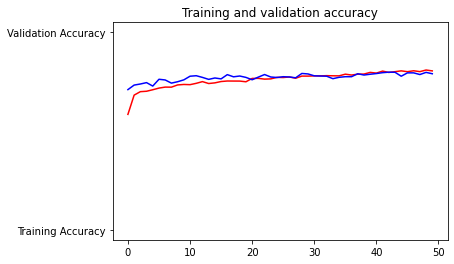

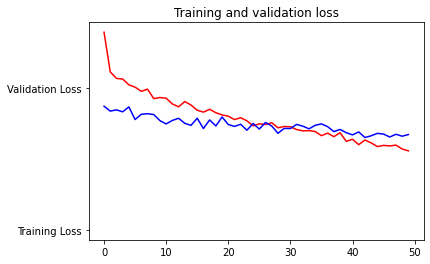

In [41]:
# PLOT LOSS AND ACCURACY
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")


plt.title('Training and validation loss')

# Desired output. Charts with training and validation metrics. No crash :)

## Unfreezing the Whole model for training

In [42]:
# Unfreeze the base model
base_pretrained_model.trainable = True

# It's important to recompile your model after you make any changes
# to the `trainable` attribute of any inner layer, so that your changes
# are take into account
model.compile(optimizer = Adam(learning_rate=0.00001), 
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

# model.build(input_shape)
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper_4 (ModuleWrap (None, 12, 12, 1664)      12642880  
_________________________________________________________________
spatial_dropout2d_4 (Spatial (None, 12, 12, 1664)      0         
_________________________________________________________________
dense_8 (Dense)              (None, 12, 12, 512)       852480    
_________________________________________________________________
flatten_4 (Flatten)          (None, 73728)             0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 73728)             294912    
_________________________________________________________________
dense_9 (Dense)              (None, 7)                 516103    
Total params: 14,306,375
Trainable params: 14,000,519
Non-trainable params: 305,856
____________________________________

##Modifying Callbacks

In [43]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

weight_path="{}_weights.best.hdf5".format('skin-lesion-ISIC2018-classification')

checkpoint = ModelCheckpoint(weight_path, monitor='val_accuracy', verbose=2, 
                             save_best_only=True, mode='max', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_accuracy',
                                   factor=0.8, patience=10, verbose=1, mode='auto', min_delta=0.0001, cooldown=5, min_lr=0.000001)

early = EarlyStopping(monitor="val_accuracy", 
                      mode="max", 
                      patience=15) # probably needs to be more patient, but kaggle time is limited

callbacks_list = [checkpoint, early, reduceLROnPlat]

##Training the unfrozen model

In [1]:
# Train end-to-end. Be careful to stop before you overfit!
history = model.fit(train_generator,
                    epochs=100,
                    verbose=1,
                    callbacks = callbacks_list,
                    validation_data=validation_generator)

NameError: ignored

## Visualize the results after Fine Tuning

Text(0.5, 1.0, 'Training and validation loss')

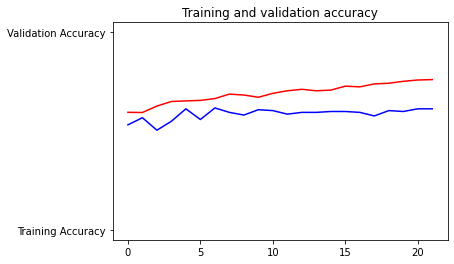

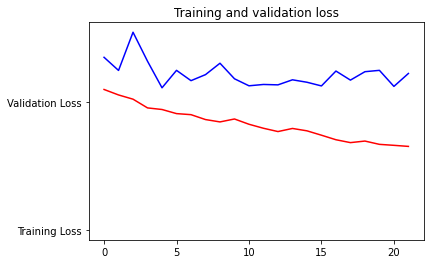

In [ ]:
# PLOT LOSS AND ACCURACY
%matplotlib inline
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")


plt.title('Training and validation loss')

# Desired output. Charts with training and validation metrics. No crash :)

## Predict result on unseen data

In [ ]:
t_x, t_y = test_x, test_y
print('Predicting on unseen test data:')
t_yp = model.predict(t_x, verbose=True)

Predicting on unseen test data:
4/4 [==============================] - 7s 2s/step


In [ ]:
count=0
label=[]
pred = []
for i in range(len(t_y)):
  label.append(np.argmax(t_y[i], axis = 0))
  pred.append(np.argmax(t_yp[i], axis = 0))
  if np.argmax(t_y[i], axis = 0) == np.argmax(t_yp[i], axis = 0):
    count +=1
accuracy = (count * 100)/ len(t_y)
print(f"Accuracy: {accuracy}") 
print(label)
print(pred)

Accuracy: 64.40677966101696
[1, 0, 2, 5, 0, 5, 0, 1, 1, 5, 0, 3, 1, 0, 0, 1, 0, 0, 3, 5, 1, 1, 3, 1, 1, 5, 4, 3, 1, 0, 2, 4, 3, 1, 4, 0, 0, 0, 1, 4, 1, 3, 0, 4, 1, 1, 0, 5, 1, 0, 0, 1, 1, 1, 5, 0, 1, 0, 0, 1, 1, 1, 5, 3, 1, 0, 2, 1, 1, 5, 0, 1, 1, 1, 4, 0, 1, 1, 0, 1, 0, 4, 0, 0, 0, 5, 0, 0, 1, 1, 3, 0, 1, 1, 4, 5, 0, 0, 0, 0, 1, 3, 1, 4, 4, 1, 3, 0, 1, 3, 0, 1, 1, 3, 1, 3, 5, 0]
[1, 0, 2, 2, 1, 0, 0, 0, 4, 2, 1, 5, 0, 0, 0, 1, 0, 0, 5, 2, 1, 1, 5, 0, 1, 5, 1, 3, 1, 0, 2, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 2, 0, 1, 1, 1, 0, 5, 1, 0, 0, 1, 1, 1, 5, 0, 1, 0, 0, 1, 1, 1, 5, 3, 1, 0, 2, 1, 1, 2, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 5, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 5, 1, 1, 1, 1, 0, 0, 1, 3, 0, 1, 1, 2, 1, 2, 0, 0]


In [ ]:
def metrics(ground_truth, pred, cls):
  tp=0
  tn=0
  fp=0
  fn=0
  for i in range(len(ground_truth)):
    if ground_truth[i] == cls and pred[i] == cls:
      tp+=1
    elif ground_truth[i] != cls and pred[i] != cls:
      tn+=1
    elif ground_truth[i] == cls and pred[i] != cls:
      fn+=1
    elif ground_truth[i] != cls and pred[i] == cls:
      fp+=1

  sens = tp / (tp + fn)
  spec = tn / (tn+fp)

  return sens, spec 

In [ ]:
cls_name = {0: "AKIEC",
            1: "BCC",
            2: "BKL",
            3: "DF",
            4: "MEL",
            5: "NV",
            6: "VASC"}
      
for cls in range(6):
  sensitivity, specificity = metrics(label, pred, cls)
  print("For %s: Sensitiivity = %.2f, Specificity = %.2f" % (cls_name[cls], sensitivity*100, specificity*100) )

For ACK: Sensitiivity = 75.68, Specificity = 87.65
For BCC: Sensitiivity = 88.37, Specificity = 74.67
For MEL: Sensitiivity = 100.00, Specificity = 93.91
For NEV: Sensitiivity = 23.08, Specificity = 100.00
For SCC: Sensitiivity = 0.00, Specificity = 99.07
For SEK: Sensitiivity = 33.33, Specificity = 95.28
